In [216]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
import pandas as pd
from utils import analyze_budget_consumption

path = "ray/criteo/optimizations/run_and_report_2024-03-16_03-28-43"
users_data_df, destinations_data_df, total_users_converted_across_destinations = analyze_budget_consumption(path, get_user_logs=False, get_destination_logs=True)

Analyze optimization  Analyze optimization 2 
1
Analyze optimization  0
1192588
1192588
1192588


In [205]:
destinations_data_df

,destination_id,num_user_ids_who_converted,avg_budget_consumption_per_requested_epoch_across_converted_users,sum_budget_consumption_per_requested_epoch_across_converted_users,avg_budget_consumption_across_requested_epochs_across_converted_users,sum_budget_consumption_across_requested_epochs_across_converted_users,max_epoch_requested_across_users,num_unique_user_ids_who_converted,optimization
0,0,7418,"[0.009534915071447743, 0.009324615799406657, 0...","[70.72999999999936, 69.16999999999858, 66.8899...",0.002696,1139.790000,56,7418,no_optimization
0,0,7418,"[0.009246862031889623, 0.009324615799406657, 0...","[68.59322255255722, 69.16999999999858, 66.8899...",0.002691,1137.653223,56,7418,monoepoch
0,0,7418,"[0.0001689434554541564, 0.0005068751685090279,...","[1.253222552558932, 3.7599999999999687, 3.5999...",0.000184,77.903223,56,7418,multiepoch
1,1,1019,"[0.0026790971540726067, 0.0026594700686947857,...","[2.729999999999986, 2.7099999999999866, 2.6799...",0.002562,271.470000,103,1019,no_optimization
1,1,1019,"[0.0026231370497512125, 0.0026594700686947857,...","[2.6729766536964856, 2.7099999999999866, 2.679...",0.002561,271.412977,103,1019,monoepoch
...,...,...,...,...,...,...,...,...,...
272,272,46,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.003158,13.800000,94,46,monoepoch
272,272,46,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000105,0.460000,94,46,multiepoch
273,273,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.003226,4.200000,92,14,no_optimization
273,273,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.003226,4.200000,92,14,monoepoch


In [206]:
total_users_converted_across_destinations

1192588

In [194]:
print(destinations_data_df["num_user_ids_who_converted"].max())
print(destinations_data_df["max_epoch_requested_across_users"].max())

477888
105


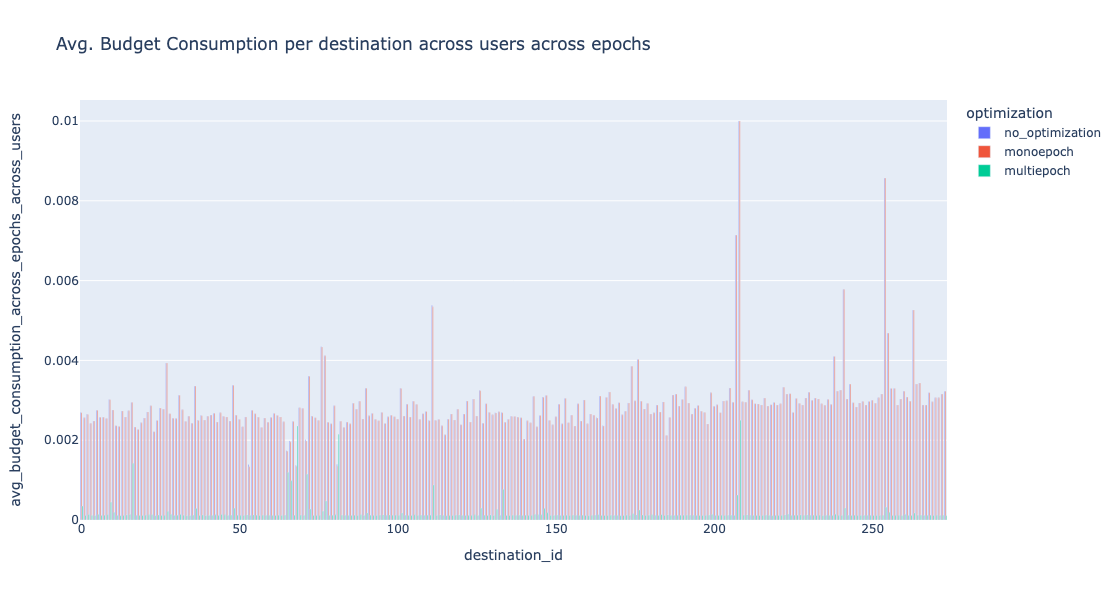

In [159]:
from utils import plot_avg_budget_per_destination_across_epochs_across_users
plot_avg_budget_per_destination_across_epochs_across_users(destinations_data_df)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


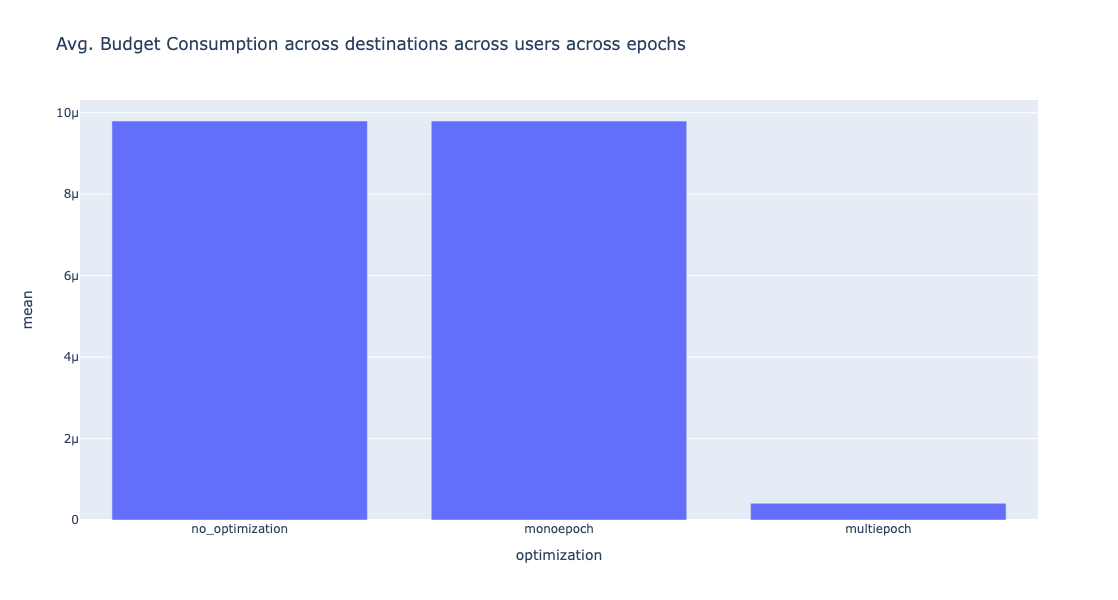

In [218]:
from utils import plot_avg_budget_across_destinations_across_epochs_across_users
plot_avg_budget_across_destinations_across_epochs_across_users(destinations_data_df, total_users_converted_across_destinations)

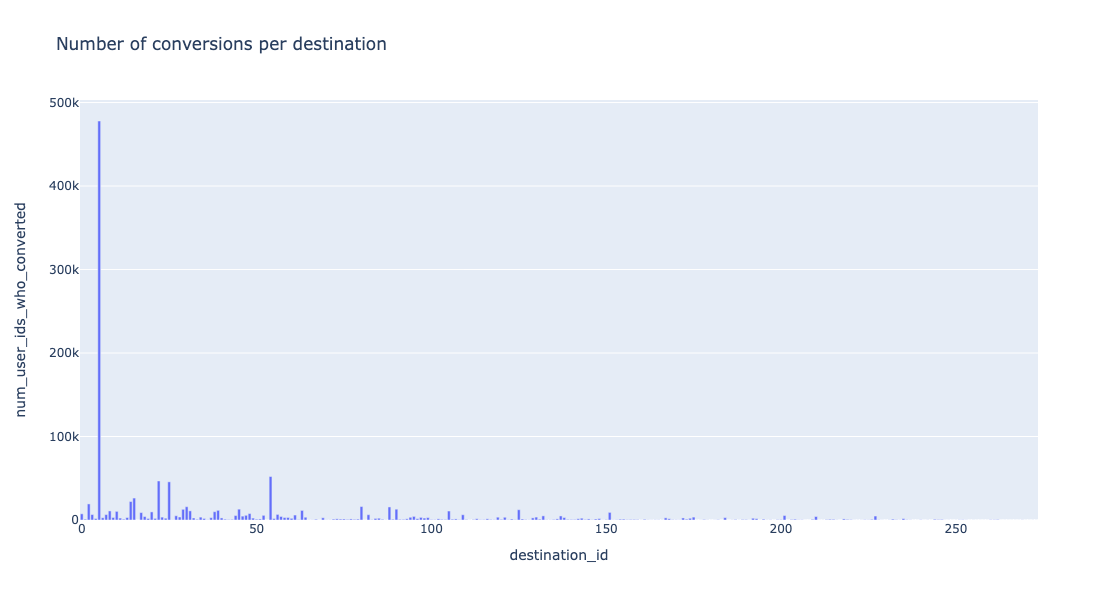

In [211]:
from utils import plot_num_conversions_per_destination
plot_num_conversions_per_destination(destinations_data_df)

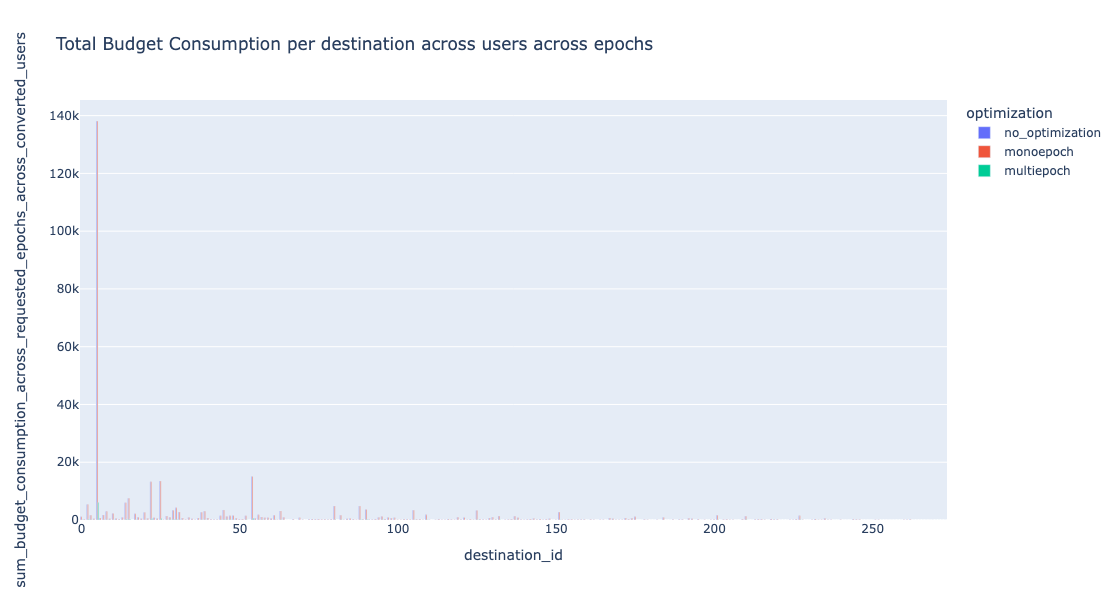

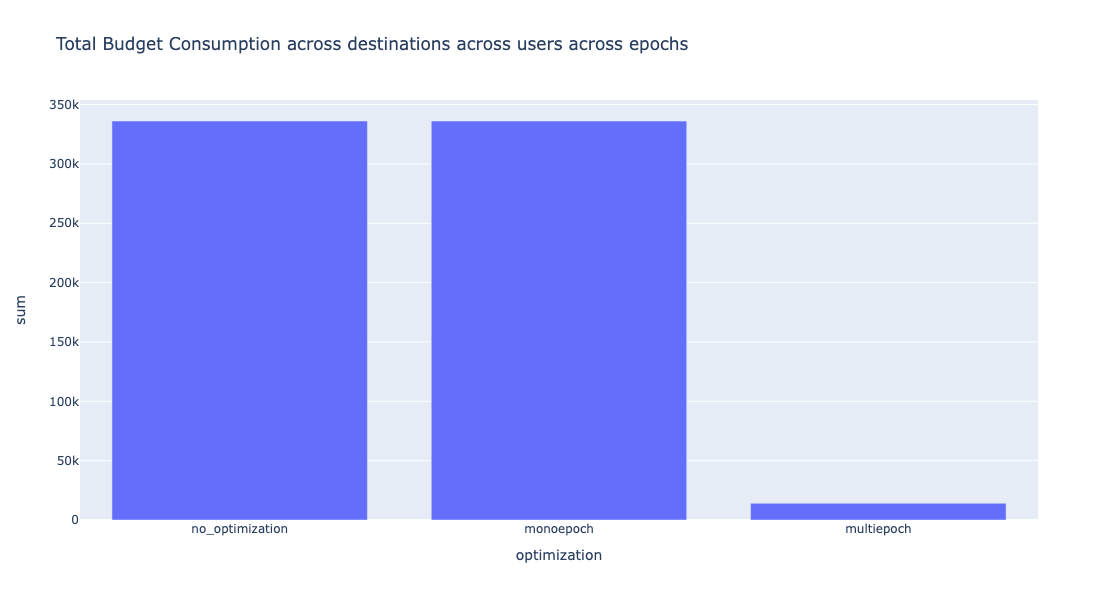

In [217]:
from utils import plot_sum_budget_per_destination_across_epochs_across_users, plot_sum_budget_across_destinations_across_epochs_across_users

plot_sum_budget_per_destination_across_epochs_across_users(destinations_data_df)
plot_sum_budget_across_destinations_across_epochs_across_users(destinations_data_df)